# Building our Neural Network

### Introduction

In the last lesson, we saw some of the data that neural networks could interpret, and explored our Fashion dataset.  In this lesson, we'll work with that dataset again, this time feeding it into a neural network, and then using the neural network to identify some images. 

### Getting our Data

Once again, we'll need to download our data, which we can do so with the following line of code:

In [1]:
import keras

(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

And then let's make sure we still have some articles of clothing.

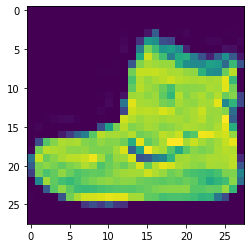

In [3]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0])

And our first label is the following.

In [5]:
y_train[0]

9

Ok, let's take a look at what these numbers correspond to make sure this makes sense.

In [6]:
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9

Ok, cool so far so good.  Let's move onto building our neural network.

### Building our Neural Network

To build our neural network, we'll use the Pytorch library.  There's no way we can understand the ins and outs of a neural network just in this lesson.  Instead, let's just see it action for now.

We'll start by importing the Pytorch library, and then can build a neural network class with the following.

> Press `shift + return` on the code below.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.W1 = nn.Linear(28*28, 64)
        self.W2 = nn.Linear(64, 64)
        self.W3 = nn.Linear(64, 64)
        self.W4 = nn.Linear(64, 10)
        
    def forward(self, X):
        A1 = torch.sigmoid(self.W1(X))
        A2 = torch.sigmoid(self.W2(A1))
        A3 = torch.sigmoid(self.W3(A2))
        Z4 = self.W4(A3)
        return F.softmax(Z4, dim = 1)

So above, we defined a *class* that creates neural networks.  A **class** is a programming concept.  If you're not familiar with term, just know that in the lines above we essentially created a factory that now can produce neural networks for us.  Want to build a neural network?  We just need to call on our factory.

In [8]:
net = Net()
net

Net(
  (W1): Linear(in_features=784, out_features=64, bias=True)
  (W2): Linear(in_features=64, out_features=64, bias=True)
  (W3): Linear(in_features=64, out_features=64, bias=True)
  (W4): Linear(in_features=64, out_features=10, bias=True)
)

Ok, so now that we created our class for building neural networks, and created a neural network itself, let's start training the neural network.

### Making a single prediction

Now remember that *training* our neural network means that we'll feed our neural network our input data, and the corresponding labels.  This should make sense.  When we called `net = Net()`, we just built a neural network fresh out of the factory.  So while it has the capacity to learn how to identify images -- it hasn't undergone it's training process yet.  

If we fed it a picture, it would just make a wild prediction as to what that actual image was.  Let's see that.

Ok, now before we feed our training data into the neural network, we'll first need change it up a little.  Currently, our training data is a numpy array.

In [9]:
type(X_train)

numpy.ndarray

We'll need to convert this into Pytorch's equivalent data structure, and make sure that every item is an integer.

In [18]:
X_train_tensor = torch.tensor(X_train).float()

In [19]:
first_obs = X_train_tensor[0].reshape(-1, 784)

In [20]:
first_obs.shape

torch.Size([1, 784])

And we'll need to `y_train` label's into a tensor, converting the data into pytorch's equivalent of an integer with the following.

> We also need to reshape the tensor -- whatever that means.  

In [42]:
y_train_tensor = torch.tensor(y_train).long().reshape(-1, 1)

In [43]:
y_train_tensor.dtype

torch.int64

And then we can make a prediction with that first observation.

In [24]:
pred = net(first_obs)
pred

tensor([[0.0867, 0.1304, 0.1206, 0.1074, 0.1088, 0.0947, 0.0645, 0.1170, 0.0879,
         0.0820]], grad_fn=<SoftmaxBackward>)

It's a little hard to interpret the above, but this is our prediction.

In [25]:
torch.argmax(pred)

tensor(1)

### Training a Neural Network

Now it's time to train our neural network.  To do so, we'll first need to initialize an optimizer and a loss function.  For the loss function, initialize cross entropy loss from the `nn` module.

In [26]:
x_loss = nn.CrossEntropyLoss()
x_loss
# CrossEntropyLoss()

CrossEntropyLoss()

In [27]:
import torch.optim as optim
adam = optim.Adam(net.parameters(), lr=0.0005)
adam

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0
)

In [91]:
x_train_tensor = torch.from_numpy(x_train).float()

Perform the following steps.

In [106]:
for epoch in range(8):
    for (x, y) in zip(x_train_tensor, y_train_tensor):
        net.zero_grad()  
        X_reshaped = x.view(-1,28*28)
        prediction_batch = net(X_reshaped)
        loss = x_loss(prediction_batch, y) 
        loss.backward() 
        adam.step()
    print(loss)

tensor(1.0554, grad_fn=<NllLossBackward>)
tensor(0.1444, grad_fn=<NllLossBackward>)
tensor(0.7173, grad_fn=<NllLossBackward>)
tensor(0.1364, grad_fn=<NllLossBackward>)
tensor(0.0828, grad_fn=<NllLossBackward>)
tensor(2.5173, grad_fn=<NllLossBackward>)
tensor(0.1435, grad_fn=<NllLossBackward>)
tensor(0.1413, grad_fn=<NllLossBackward>)


### Evaluating our Neural Network

Now let's get a sense of how our neural network performed.  First make  predictions on the first twenty observations in the testset.

In [125]:
x_test = torch.tensor(x_test).float()

In [126]:
predictions_test = net(x_test.view(-1, 28*28).float())

In [127]:
torch.exp(predictions_test[:1])

# tensor([[4.4961e-08, 1.2412e-05, 4.5766e-09, 9.3961e-07, 1.2311e-06, 9.5997e-04,
#          4.3604e-08, 4.5264e-03, 2.0135e-05, 9.9448e-01]],
#        grad_fn=<ExpBackward>)

tensor([[1.8848e-12, 2.2202e-16, 4.5645e-16, 1.6148e-15, 1.4248e-14, 4.9672e-02,
         3.9909e-13, 7.0305e-01, 8.7145e-04, 2.4641e-01]],
       grad_fn=<ExpBackward>)

In [128]:
hard_predictions = torch.argmax(predictions_test, axis = 1)

In [129]:
hard_predictions[:10]

tensor([7, 2, 1, 1, 2, 1, 2, 2, 8, 7])

In [130]:
y_test[:10]

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7], dtype=uint8)

Looking good so far.  Next, check the accuracy of our neural network on our testset.

In [133]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, hard_predictions)

# 0.8303

0.7022

So we can see that our neural network identifies $.70$ of the data correctly.  Perhaps not perfect, but not too bad either.

### Summary

In this lesson, we trained a neural network in Pytorch.  Nice work!!

### Resources

[Colab Deeep Learning](https://colab.research.google.com/github/margaretmz/deep-learning/blob/master/fashion_mnist_keras.ipynb#scrollTo=d44TznbgZZgm)

[Log Softmax](https://stats.stackexchange.com/questions/436766/cross-entropy-with-log-softmax-activation)